<a href="https://colab.research.google.com/github/leetwin1115/medical-data/blob/main/11_tf_binding_prediction_rna_inferience_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepChem 설치
Colab 노트북에 DeepChem 설치

tensorflow 기반 모델을 사용할 것이므로 pip install 명령에 [tensorflow]를 추가하여 필요한 종속성도 설치

In [ ]:
# DeepChem 설치시 Keras 종속성 버전 일치를 위해 아래 환경 변수 설정 후 import 진행
import os
os.environ["TF_USE_LEGACY_KERAS"] = '1'

In [ ]:
!pip install deepchem[tensorflow]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 32.3 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
!pip install tf_keras

In [ ]:
import deepchem as dc
dc.__version__

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


'2.8.0'

### warning 메시지 생략

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

# 전사인자 결합 예측 모델

- JUND 전사 인자의 결합 예측을 위한 CNN 모델 생성
- 2차원 이미지가 아닌 1차원 데이터 사용하는 CNN 모델

### 라이브러리 불러오기

In [ ]:
import deepchem as dc
import tensorflow as tf
import tensorflow.keras.layers as layers

### 데이터 불러오기 및 확인

In [ ]:
train = dc.data.DiskDataset('/content/drive/MyDrive/2025-1/md/data/train_dataset')
valid = dc.data.DiskDataset('/content/drive/MyDrive/2025-1/md/data/valid_dataset')

ValueError: No Metadata found in the path /content/drive/MyDrive/2025-1/md/data/train_dataset

In [ ]:
train.X.shape

NameError: name 'train' is not defined

In [ ]:
train.y.shape

NameError: name 'train' is not defined

In [ ]:
train

NameError: name 'train' is not defined

### 모델 생성

In [ ]:
features = tf.keras.Input(shape=(101, 4))
prev = features

for i in range(3):
    prev = layers.Conv1D(filters=15, kernel_size=10, activation=tf.nn.relu, padding='same')(prev)
    prev = layers.Dropout(rate=0.5)(prev)

logits = layers.Dense(units=1)(layers.Flatten()(prev))
output = layers.Activation(tf.math.sigmoid)(logits)

In [ ]:
keras_model = tf.keras.Model(inputs=features, outputs=[output, logits])

model = dc.models.KerasModel(
    keras_model,
    loss=dc.models.losses.SigmoidCrossEntropy(),
    output_types=['prediction', 'loss'],
    batch_size=1000,
    model_dir='tf')

### 모델 학습 및 평가

In [ ]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
for i in range(20):
    model.fit(train, nb_epoch=10)
    print(model.evaluate(train, [metric]))
    print(model.evaluate(valid, [metric]))

NameError: name 'train' is not defined

# 모델 수정
- Dense층 학습 시 전사 인자 조절에 관여하는 RNA 간섭 feature 추가
- feature 레이어가 2개라 fit함수 사용 불가능
- 배치별 반복 학습 수행
- iterbatches() 함수를 통해 모델에 필요한 입력 데이터 배치별 처리

In [ ]:
import numpy as np

In [ ]:
span_accessibility = {}
for line in open('/content/drive/MyDrive/2025-1/md/data/accessibility.txt'):
    fields = line.split()
    span_accessibility[fields[0]] = float(fields[1])

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/2025-1/md/data/accessibility.txt'

In [ ]:
span_accessibility

{}

In [ ]:
features = tf.keras.Input(shape=(101, 4))
accessibility = tf.keras.Input(shape=(1,))

prev = features
for i in range(3):
    prev = layers.Conv1D(filters=15, kernel_size=10, activation=tf.nn.relu, padding='same')(prev)
    prev = layers.Dropout(rate=0.5)(prev)

prev = layers.Concatenate()([layers.Flatten()(prev), accessibility])

logits = layers.Dense(units=1)(prev)
output = layers.Activation(tf.math.sigmoid)(logits)
keras_model = tf.keras.Model(inputs=[features, accessibility], outputs=[output, logits])

model = dc.models.KerasModel(
    keras_model,
    loss=dc.models.losses.SigmoidCrossEntropy(),
    output_types=['prediction', 'loss'],
    batch_size=1000,
    model_dir='chromatin')

In [ ]:
def generate_batches(dataset, epochs):
    for epoch in range(epochs):
        for X, y, w, ids in dataset.iterbatches(batch_size=1000, pad_batches=True):
            yield ([X, np.array([span_accessibility[id] for id in ids])], [y], [w])

### 성능 평가

In [ ]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
for i in range(20):
    model.fit_generator(generate_batches(train, epochs=10))
    print(model.evaluate_generator(generate_batches(train, 1), [metric]))
    print(model.evaluate_generator(generate_batches(valid, 1), [metric]))

NameError: name 'generate_batches' is not defined

# RNA 간섭 예측 모델
- RNA 서열을 입력 데이터로 사용해 RNA 간섭의 효과 예측하는 CNN 모델

In [ ]:
import matplotlib.pyplot as plt

### 데이터 불러오기 및 확인

In [ ]:
train = dc.data.DiskDataset('/content/drive/MyDrive/2025-1/md/data/train_siRNA')
valid = dc.data.DiskDataset('/content/drive/MyDrive/2025-1/md/data/valid_siRNA')

ValueError: No Metadata found in the path /content/drive/MyDrive/2025-1/md/data/train_siRNA

In [ ]:
train.X.shape

NameError: name 'train' is not defined

In [ ]:
train.y.shape

NameError: name 'train' is not defined

In [ ]:
train.X

NameError: name 'train' is not defined

### 모델 생성

In [ ]:
features = tf.keras.Input(shape=(21, 4))
prev = features
for i in range(2):
    prev = layers.Conv1D(filters=10, kernel_size=10, activation=tf.nn.relu, padding='same')(prev)
    prev = layers.Dropout(rate=0.3)(prev)
output = layers.Dense(units=1, activation=tf.math.sigmoid)(layers.Flatten()(prev))
keras_model = tf.keras.Model(inputs=features, outputs=output)
model = dc.models.KerasModel(
    keras_model,
    loss=dc.models.losses.L2Loss(),
    batch_size=1000,
    model_dir='rnai')

### 모델 학습 및 평가

In [ ]:
train_scores = []
valid_scores = []

In [ ]:
metric = dc.metrics.Metric(dc.metrics.pearsonr, mode='regression')

for i in range(20):
    model.fit(train, nb_epoch=10)
    train_score = model.evaluate(train, [metric])['pearsonr']
    valid_score = model.evaluate(valid, [metric])['pearsonr']

    train_scores.append(train_score)
    valid_scores.append(valid_score)

    print(train_score)
    print(valid_score)

NameError: name 'train' is not defined

### 모델 성능 시각화

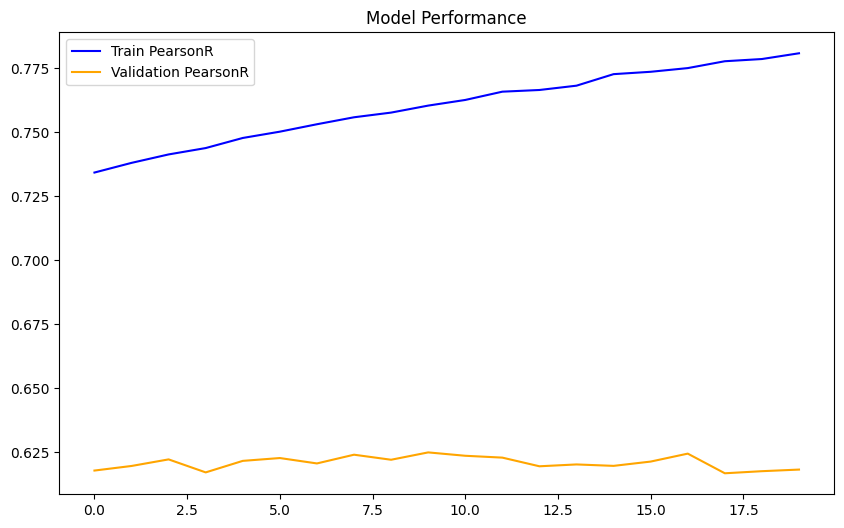

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_scores, label='Train PearsonR', color='blue')
plt.plot(valid_scores, label='Validation PearsonR', color='orange')

plt.title('Model Performance')
plt.legend()
plt.show()